# Pascal VOC challenge

### 필요 모듈 로드

In [1]:
import os
from IPython.display import clear_output
%pip install wandb==0.16.0 -q
%pip install --upgrade datasets -q
clear_output(wait=False)


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import os
import albumentations as A
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow import keras
import math
import random
import pickle
from skimage.io import imread, imshow,show
from skimage.transform import resize
from glob import glob
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import wandb
clear_output(wait=False)

In [3]:
from datasets import load_dataset
dataset = load_dataset("nateraw/pascal-voc-2012")

### CONSTANT

In [4]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256

## 데이터 EDA

In [5]:
# 데이터셋의 기본 정보 출력
print("데이터셋 정보:")
print(dataset)



데이터셋 정보:
DatasetDict({
    train: Dataset({
        features: ['image', 'mask'],
        num_rows: 1464
    })
    val: Dataset({
        features: ['image', 'mask'],
        num_rows: 1449
    })
})


In [6]:
test_dataset=dataset["train"]

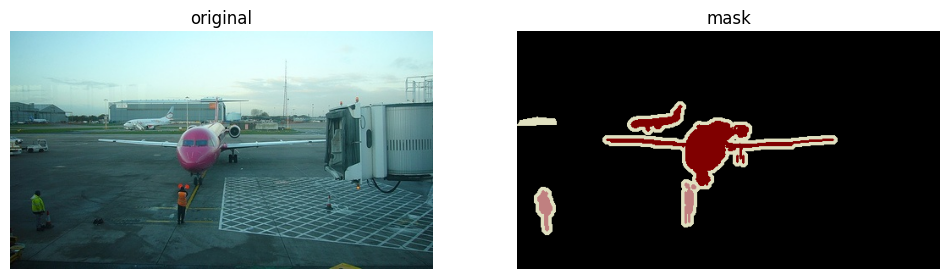

In [7]:
# 첫 번째 데이터 샘플을 로드
first_sample = test_dataset[0]
image = first_sample['image']
mask = first_sample['mask']

# 이미지와 마스크 표시
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 원본 이미지
ax[0].imshow(image)
ax[0].set_title('original')
ax[0].axis('off')

# 마스크 이미지
ax[1].imshow(mask)
ax[1].set_title('mask')
ax[1].axis('off')

plt.show()


In [8]:
from PIL import Image
import numpy as np

# 이미지와 마스크를 NumPy 배열로 변환
input_images = np.array(test_dataset[0]['image'])
input_labels = np.array(test_dataset[0]['mask'])

# 변환된 배열의 형태 확인
print("Images shape:", input_images.shape)
print("Labels shape:", input_labels.shape)



Images shape: (281, 500, 3)
Labels shape: (281, 500, 3)


In [9]:
import numpy as np
from PIL import Image

def extract_class_color_mapping(masks):
    """
    마스크 이미지들에서 클래스별 색상 매핑을 추출하는 함수
    :param masks: 마스크 이미지의 리스트
    :return: 클래스와 색상의 매핑 딕셔너리
    """
    color_mapping = {}
    class_id = 0

    for mask in masks:
        # 마스크 이미지를 NumPy 배열로 변환
        mask_np = np.array(mask)
        # 고유한 색상 찾기
        unique_colors = np.unique(mask_np.reshape(-1, mask_np.shape[2]), axis=0)

        for color in unique_colors:
            # 색상을 튜플로 변환
            color_tuple = tuple(color)
            # 새로운 색상이면 클래스 ID 할당
            if color_tuple not in color_mapping:
                color_mapping[color_tuple] = class_id
                class_id += 1

    return color_mapping




def map_integer_mask_to_color(integer_mask, reverse_mapping):
    color_mask = np.zeros((integer_mask.shape[0], integer_mask.shape[1], 3), dtype=np.uint8)
    for row in range(integer_mask.shape[0]):
        for col in range(integer_mask.shape[1]):
            class_idx = integer_mask[row, col]
            color = reverse_mapping[class_idx]
            # 컬러 값을 [0, 255] 범위로 스케일링
            scaled_color = np.clip(color, 0, 255)
            color_mask[row, col] = scaled_color

    return color_mask
def create_inverse_mapping(class_color_mapping):
    """
    클래스 ID에서 색상으로의 역 매핑을 생성하는 함수
    :param class_color_mapping: 클래스와 색상의 매핑 딕셔너리
    :return: 역 매핑 딕셔너리
    """
    inverse_mapping = {class_id: color for color, class_id in class_color_mapping.items()}
    return inverse_mapping

In [10]:
# 데이터셋에서 마스크 목록 추출
masks = [sample['mask'] for sample in test_dataset]
pickle_file = 'class_color_mapping.pkl'
if not os.path.exists(pickle_file):
    # masks 변수는 이미 정의되어 있어야 합니다.
    class_color_mapping = extract_class_color_mapping(masks)

    # 추출한 매핑을 pickle 파일로 저장
    with open(pickle_file, 'wb') as file:
        pickle.dump(class_color_mapping, file)
else:
    # 파일이 이미 존재하는 경우, pickle 파일에서 데이터 불러오기
    with open(pickle_file, 'rb') as file:
        class_color_mapping = pickle.load(file)

In [11]:
pickle_file_inverse_mapping = 'inverse_mapping.pkl'
if not os.path.exists(pickle_file_inverse_mapping):

    inverse_mapping = create_inverse_mapping(class_color_mapping)
    # 추출한 매핑을 pickle 파일로 저장
    with open(pickle_file_inverse_mapping, 'wb') as file:
        pickle.dump(inverse_mapping, file)
else:
    # 파일이 이미 존재하는 경우, pickle 파일에서 데이터 불러오기
    with open(pickle_file_inverse_mapping, 'rb') as file:
        inverse_mapping = pickle.load(file)

In [12]:
print(class_color_mapping)
print(inverse_mapping)

{(0, 0, 0): 0, (128, 0, 0): 1, (192, 128, 128): 2, (224, 224, 192): 3, (0, 64, 128): 4, (64, 0, 128): 5, (192, 0, 0): 6, (128, 128, 0): 7, (128, 0, 128): 8, (0, 0, 128): 9, (192, 128, 0): 10, (128, 192, 0): 11, (64, 128, 128): 12, (192, 0, 128): 13, (64, 128, 0): 14, (0, 128, 0): 15, (128, 128, 128): 16, (64, 0, 0): 17, (0, 192, 0): 18, (0, 128, 128): 19, (0, 64, 0): 20, (128, 64, 0): 21}
{0: (0, 0, 0), 1: (128, 0, 0), 2: (192, 128, 128), 3: (224, 224, 192), 4: (0, 64, 128), 5: (64, 0, 128), 6: (192, 0, 0), 7: (128, 128, 0), 8: (128, 0, 128), 9: (0, 0, 128), 10: (192, 128, 0), 11: (128, 192, 0), 12: (64, 128, 128), 13: (192, 0, 128), 14: (64, 128, 0), 15: (0, 128, 0), 16: (128, 128, 128), 17: (64, 0, 0), 18: (0, 192, 0), 19: (0, 128, 128), 20: (0, 64, 0), 21: (128, 64, 0)}


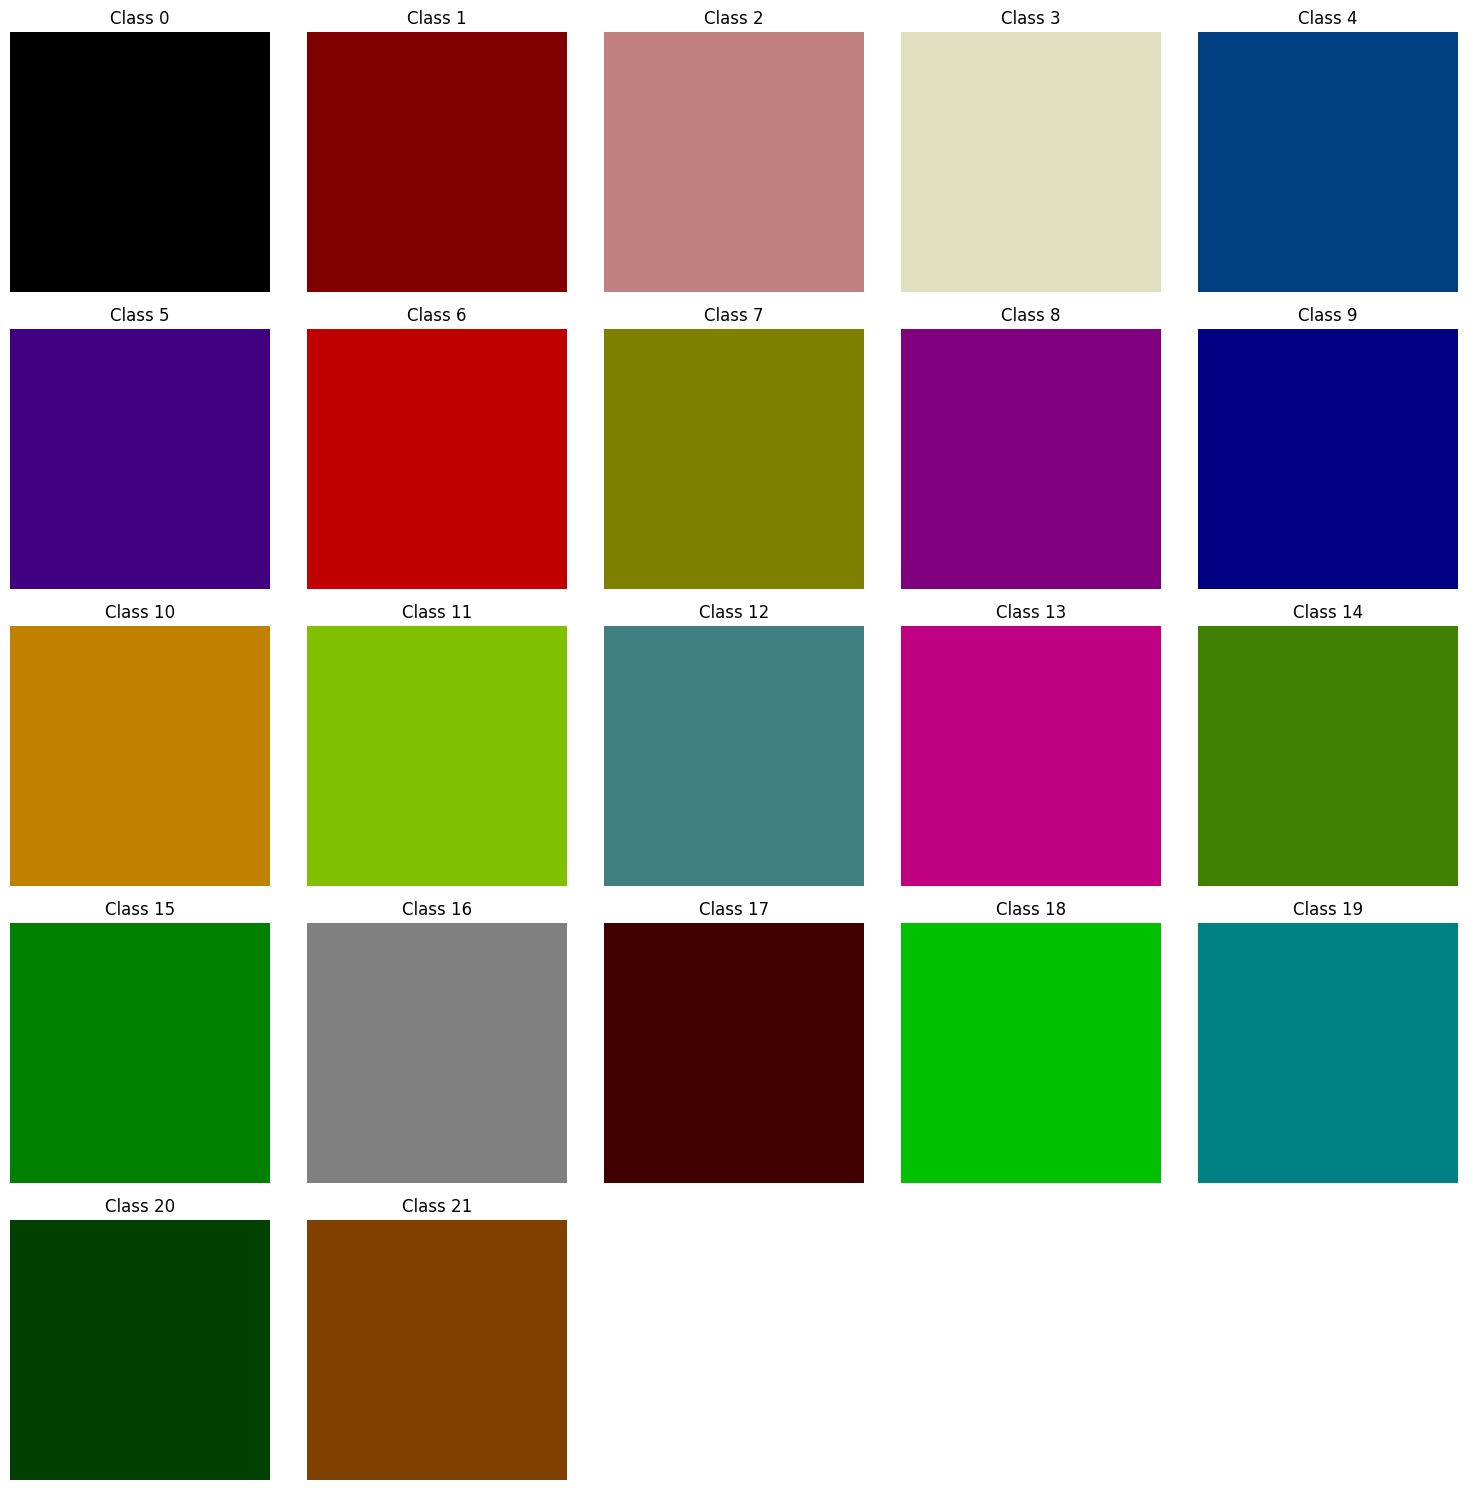

In [13]:
# 5행 5열의 서브플롯 생성
plt.figure(figsize=(15, 15))
for class_id, color in inverse_mapping.items():
    ax = plt.subplot(5, 5, class_id + 1)
    ax.set_title(f"Class {class_id}")
    ax.imshow(np.full((10, 10, 3), color, dtype=np.uint8))  # 색상으로 채운 작은 이미지 생성
    ax.axis('off')

# 나머지 빈 서브플롯 숨기기
for i in range(len(inverse_mapping) + 1, 26):
    ax = plt.subplot(5, 5, i)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 데이터 전처리

In [14]:
from PIL import ImageOps
def map_colors_to_labels(seg, color_mapping):
    # 세그멘테이션 마스크의 높이와 너비를 얻습니다.
    height, width = seg.shape[:2]
    non_zero_indices = np.nonzero(seg)

    # 행과 열 인덱스를 튜플로 묶어 딕셔너리 생성
    index_dict = {}
        
    for i in range(len(non_zero_indices[0])):
        key = (non_zero_indices[0][i], non_zero_indices[1][i])
        index_dict[key] = 1             
    # 새로운 레이블 배열을 생성합니다.
    label_seg = np.zeros((height, width), dtype=np.int32)
    for i in index_dict.keys():
        
        y = i[0]
        x = i[1]
        
        # 현재 픽셀의 RGB 값을 가져옵니다.
        pixel = tuple(seg[y, x])

        # RGB 값에 해당하는 레이블을 찾아 할당합니다.
        label_seg[y, x] = color_mapping.get(pixel, 0)  # 기본값으로 0을 사용
            
    return label_seg
def data_concat(dataset):
    
    img_arr = []
    seg_arr = []

    img_arr_temp = dataset['train']['image'] + dataset['val']['image']

    seg_arr_temp = dataset['train']['mask'] + dataset['val']['mask']
    
    for img, seg in zip(img_arr_temp, seg_arr_temp):
        img = np.array(img.resize((IMG_WIDTH, IMG_HEIGHT),Image.NEAREST))
        seg = np.array(seg.resize((IMG_WIDTH, IMG_HEIGHT),Image.NEAREST))
        label_seg = map_colors_to_labels(seg, class_color_mapping)
        img_arr.append(img)
        seg_arr.append(label_seg)
    
    return np.array(img_arr), np.array(seg_arr)

In [15]:
full_dataset = tf.data.Dataset.from_tensor_slices(data_concat(dataset))
print(full_dataset)

2024-01-12 00:45:46.290379: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-12 00:45:46.303686: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-12 00:45:46.307399: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

<_TensorSliceDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(256, 256), dtype=tf.int32, name=None))>


In [16]:
DATASET_SIZE = 2913
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.2 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

full_dataset = full_dataset.shuffle(buffer_size = DATASET_SIZE)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [17]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

def load_image_train(input_image, input_mask):
    input_mask = input_mask[ ..., np.newaxis]
    

    # random flip the image and mask
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    input_mask = input_mask[:, :, 0]
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask
def load_image_test(input_image, input_mask):
    input_mask = input_mask[np.newaxis, ...]
    
    
    input_mask = input_mask[0]
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [18]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = train_size // BATCH_SIZE
train = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val   = train_dataset.map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_dataset.map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)
val_dataset = val.batch(BATCH_SIZE)

In [19]:
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
# 그래프를 노트북 안에 그리기 위해 설정
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
# ttf 폰트 전체갯수
print(len(font_list)) 
# fname 옵션을 사용하는 방법
path = 'MaruBuri-Light.ttf'
fontprop = fm.FontProperties(fname=path, size=18)

38


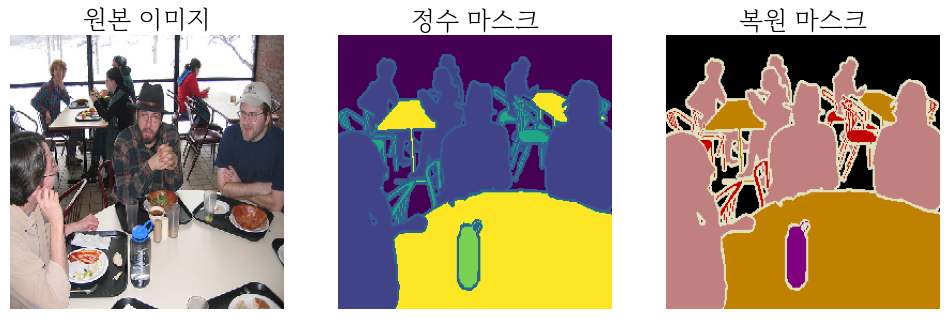

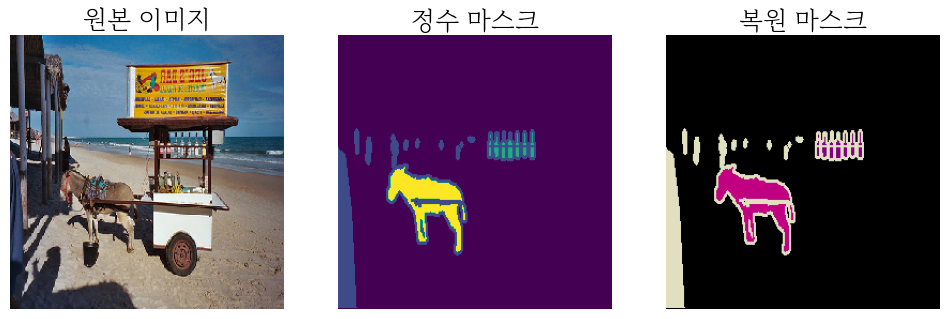

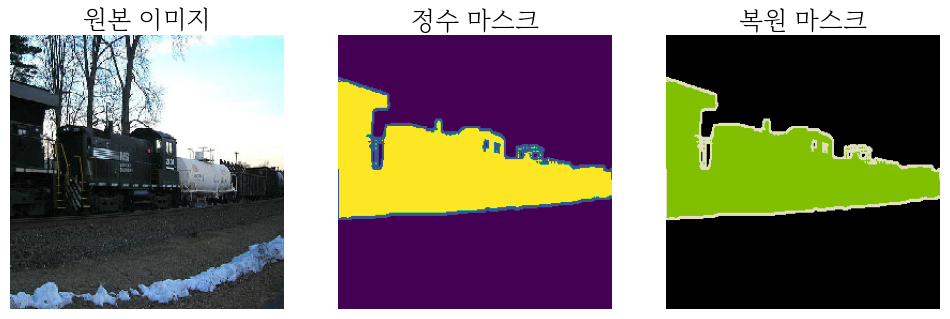

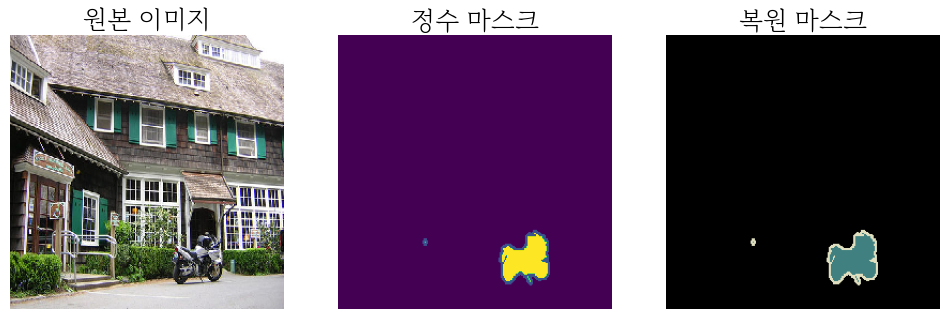

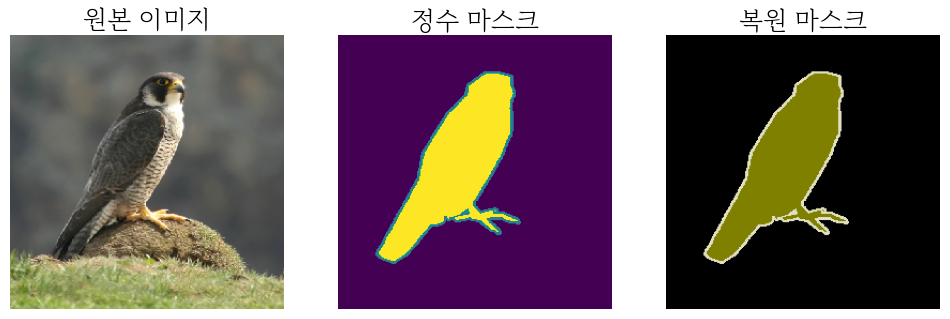

In [20]:
for image, mask in train.take(5):
    sample_image, sample_mask = image, mask
    restored_color_mask = map_integer_mask_to_color(np.array(sample_mask), inverse_mapping)
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
     # 원본 이미지
    clear_output()
    ax[0].imshow(sample_image)
    ax[0].set_title('원본 이미지' , fontproperties=fontprop)
    ax[0].axis('off')
    # 정수 마스크 이미지
    ax[1].imshow(sample_mask)
    ax[1].set_title('정수 마스크', fontproperties=fontprop)
    ax[1].axis('off')
    # 복원 마스크 이미지
    ax[2].imshow(restored_color_mask)
    ax[2].set_title('복원 마스크', fontproperties=fontprop)
    ax[2].axis('off')

## 모델 구성

In [22]:
def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
    x = tf.keras.layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=tf.keras.initializers.HeNormal(),
        )(block_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = tf.keras.layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = tf.keras.layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = tf.keras.layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output
def DeeplabV3(image_size, num_classes):
    model_input = tf.keras.Input(shape=(image_size, image_size, 3))
    resnet50 = tf.keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = tf.keras.layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = tf.keras.layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = tf.keras.layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = tf.keras.layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    model = tf.keras.Model(inputs=model_input, outputs=model_output)
    
    return model

## 훈련

In [23]:

sweep_config = {
    "name": "sweep_test_cv",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.0001,
            "max" : 0.01
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            }
                    
        }
    }

In [24]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = val_size//BATCH_SIZE//VAL_SUBSPLITS
OUTPUT_CHANNELS = 22


In [25]:
import os
os.environ["WANDB_NOTEBOOK_NAME"]="deeplabv3.ipynb"

In [26]:

wandb.login(key = '93419eb8a19caec1b5a855c81c59767847da9775')

wandb: Currently logged in as: dudnjsckrgo. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [27]:



def train():
    default_config = {
        "input" : (256,256,3),
        "learning_rate" : 1e-4,
        "optimizer" : "adam",
        "metrics" : ["accuracy"],
        "epoch" : 5,
        "batch_size" : 32
    }

    wandb.init(config = default_config)
    config = wandb.config


    # 머신 러닝 학습때 여러가지 optimzier를 사용할 경우나 learning rate를 조절할 경우에는 아래와 같은 형태의 코드를 응용합니다.

    if config.optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate = config.learning_rate)
    
    img_height = 256
    model = DeeplabV3(img_height, num_classes=22)
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    # WandbCallback 함수는 후술합니다.
    model.fit(train_dataset,
              epochs=config.epoch,
              steps_per_epoch=STEPS_PER_EPOCH,
              validation_steps=VALIDATION_STEPS,
              validation_data=val_dataset)
    
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=2)
    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

In [28]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = None,
                       project = 'DLThon')

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=5)

Create sweep with ID: nydnol3s
Sweep URL: https://wandb.ai/happybin2013/DLThon/sweeps/nydnol3s


wandb: Agent Starting Run: vcf0fo4n with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 0.004971342981583524
wandb: Currently logged in as: happybin2013. Use `wandb login --relogin` to force relogin


Epoch 1/5


wandb: Ctrl + C detected. Stopping sweep.


2024-01-12 00:51:20.336434: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-01-12 00:51:28.459761: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 2164260864 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 51118080/12408979456
2024-01-12 00:51:28.459775: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                     10650124288
InUse:                     11870440449
MaxInUse:                  11870440449
NumAllocs:                        3847
MaxAllocSize:               2365612048
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-01-12 00:51:28.459807: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_si

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

In [ ]:
img_height = 224
model = DeeplabV3(img_height, num_classes=22)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:

MODEL_PATH = './deeplabv3.keras'
callbacks = tf.keras.callbacks.ModelCheckpoint(
    filepath = MODEL_PATH,
    save_best_only = True,
    save_weights_only = False,
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1
)

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_dataset,
                          callbacks = [callbacks,
                        WandbMetricsLogger(log_freq=5),
                        WandbModelCheckpoint("models")
        ])

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(np.array(display_list[i]))
        plt.axis('off')
    plt.show()
show_predictions(test_dataset.shuffle(buffer_size=64), num =10)

## 평가

In [ ]:
model.evaluate(test_dataset)


In [ ]:
!mkdir source
!mkdir mask

In [ ]:
cnt = 0
for image, mask in train_dataset.take(10):
    pred_mask = model.predict(image)
    pred_mask = create_mask(pred_mask)
    pred_mask = (np.array(pred_mask) !=0).astype(int)
#     print(image[0].shape)
#     print(pred_mask.shape)
    Image.fromarray((np.array(image[0]*255).astype(np.uint8))).save(f"source/source_{cnt}.jpg")
    Image.fromarray((pred_mask[:,:,0]*255).astype(np.uint8)).save(f"mask/mask_{cnt}.jpg")
    display([image[0], pred_mask[:, :, 0], image[0] * pred_mask])
    cnt += 1

## Grad-CAM 시각화

In [ ]:
import cv2 
import copy
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = np.array(input['image'])
    mask = np.array(input['mask'])
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.
    integer_mask= map_colors_to_labels(mask, class_color_mapping)
    integer_mask= tf.expand_dims(integer_mask, -1)
    integer_mask = tf.image.resize(integer_mask, [224, 224])
    integer_mask= tf.squeeze(integer_mask, -1)
    return image, integer_mask
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = np.array(item['image']).shape[1]
    height = np.array(item['image']).shape[0]
    img_tensor, mask_tensor = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(tf.expand_dims(img_tensor, 0))
        # 배경 클래스 제외
        non_background_predictions = predictions[:, :, :, 1:]
        # 예시 출력
        print("배경을 제외한 예측값 형태:", non_background_predictions.shape)
        # 가정: `true_labels`는 해당 이미지의 실제 레이블을 포함하고 있음
        # `from_logits=True`는 모델 출력이 확률이 아닌 로짓임을 나타냄
        loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        mask_tensor= tf.expand_dims(mask_tensor, -1)
        mask_tensor= tf.expand_dims(mask_tensor, 0)
        loss = loss_function(mask_tensor, non_background_predictions)
        predictions = tf.squeeze(predictions, axis=0)
        predicted_classes = tf.argmax(predictions, axis=2)
        predicted_classes= tf.expand_dims(predicted_classes, -1)
        output=conv_output[0]
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.
    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image
grad_cam_image = generate_grad_cam(model, 'conv2d_transpose_13', dataset[3])
print(grad_cam_image)
plt.imshow(grad_cam_image, cmap='jet') 
plt.show()
plt.imshow(dataset[3]["image"])
plt.show()